In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from helper import get_data, prepare_data
from talib.abstract import SMA, EMA

Для временного ряда цен закрытия (Close) ПАО "Сбербанк" (SBER) построить технические индикаторы:

1. индекс относительной силы RSI(14, 20, 80)
2. Полосу Болинжера ВВ(21, 2)

Указание: применить библиотеку TA-lib

In [2]:
TICKER = 'SBER'
start_date = '2022-08-24'
end_date = '2023-09-24'

In [3]:
df = get_data(TICKER, start_date, end_date)
df = prepare_data(df)
df.head()

,open,close,high,low,value,Date
0,130.60,128.15,131.64,127.85,5.940974e+09,2022-08-24
1,128.15,128.18,129.81,127.10,4.630468e+09,2022-08-25
2,128.02,130.40,130.50,127.62,4.251007e+09,2022-08-26
3,130.12,131.17,131.40,129.52,5.342794e+09,2022-08-29
4,131.17,130.05,132.60,129.65,6.706724e+09,2022-08-30


In [4]:
dates = df['Date']
open_cost = df['open']
close_cost = df['close']

In [5]:
period = 21

In [6]:
inputs = {'close': close_cost}
talib_sma = SMA(inputs, timeperiod=period, price='close')
talib_ema = EMA(inputs, timeperiod=period, price='close')

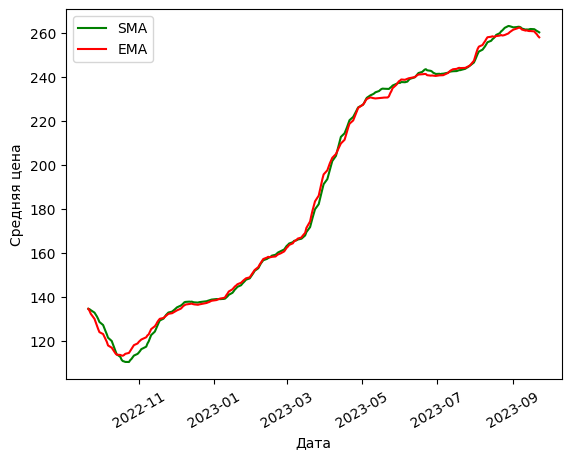

In [8]:
plt.plot(dates, talib_sma, label='SMA', color='green')
plt.plot(dates, talib_ema, label='EMA', color='red')

plt.xticks(rotation=30)
plt.xlabel('Дата')
plt.ylabel('Средняя цена')

plt.legend()
plt.show()

In [9]:
treshold = 1e-1

indexes = np.where(np.abs(talib_sma - talib_ema) < treshold, True, False)
sma_points = talib_sma[indexes]
ema_points = talib_ema[indexes]

pd.DataFrame({'SMA': sma_points, 'EMA': ema_points, 'delta': np.abs(sma_points - ema_points)})

,SMA,EMA,delta
0,134.625238,134.625238,0.000000
1,130.935238,130.955953,0.020714
2,139.068095,139.080622,0.012527
3,227.309048,227.362034,0.052986
4,239.741905,239.837439,0.095534
5,240.356190,240.270399,0.085792
6,242.210000,242.300108,0.090108
7,258.087143,258.184555,0.097412


In [10]:
windows_sizes = [14, 20, 80]
bollinger_intervals = [21, 2]

In [11]:
def calculate_RSI(df: pd.DataFrame, ema_vec: np.array, window: int):
    close = df['close'].values
    diff = np.concatenate((np.array([0]), close[1:] - close[:-1]))

    rs = np.zeros(len(close))
    for i in range(window, len(close)):
        _diff = diff[i-window:i]
        up_indexes = np.where(_diff > 0)
        down_indexes = np.where(_diff < 0)
        ema_up = (ema_vec[i-window:i][up_indexes]).sum()
        ema_down = np.abs((ema_vec[i-window:i][down_indexes]).sum())
        rs[i] += ema_up / (ema_down + 1e-12)
        
    rsi = 100 - 100 / (1 + rs)

    return rsi
        

In [12]:
ema_vec = np.concatenate((np.zeros(period), talib_ema[period:]))
rsi = []
for window in windows_sizes:
    rsi.append(calculate_RSI(df, ema_vec, window))

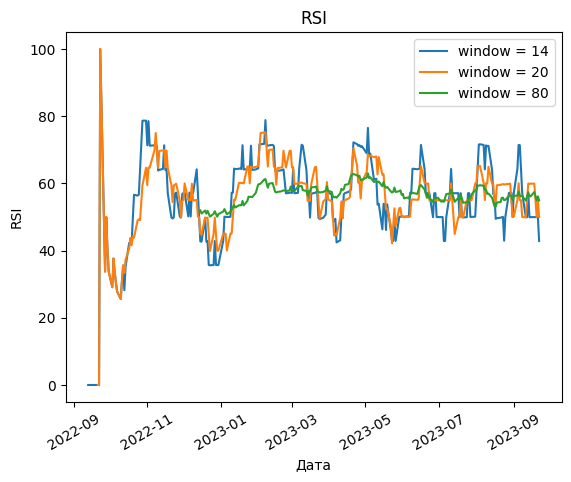

In [17]:
for _rsi, window in zip(rsi, windows_sizes):
    plt.plot(dates[window:], _rsi[window:], label=f'window = {window}')


plt.xticks(rotation=30)
plt.xlabel('Дата')
plt.ylabel('RSI')

plt.title('RSI')
plt.legend()
plt.show()

In [18]:
def std(x: np.array):
    return (((x - x.mean())**2).sum() / (len(x) - 1))**0.5

def make_bollinger_lines_step(df, window):
    close = df['close'].values
    stds = np.zeros(len(close))
    for i in range(window, len(close)):
        stds[i] += std(close[i-window:i])
    return close + 2 * stds, close - 2 * stds        

In [19]:
up_line, down_line = make_bollinger_lines_step(df, 21)

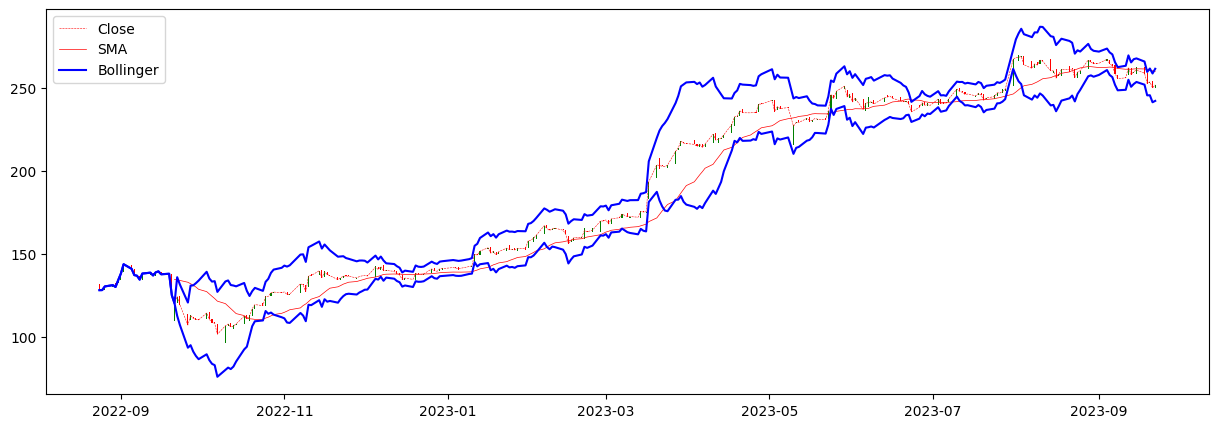

In [24]:
plt.figure(figsize=(15,5))

# draw candles
for i in range(len(df)):

    open = df.loc[i, 'open']
    close = df.loc[i, 'close']
    high = df.loc[i, 'high']
    low = df.loc[i, 'low']

    top, bottom = ..., ...
    
    color = {1: 'green', -1: 'red'}
    
    if open >= close:
        top = open
        bottom = close
        
    else:
        top = close
        bottom = open
        
    upper_shadow = high - top
    down_shadow = bottom - low
    body = top - bottom
    
    body_width = 0.4
    shadow_width = .05

    if close - open > 0:
        sign = 1
    else:
        sign = -1
    color = color[sign]
    
    plt.bar(x=dates[i], height=body, width=body_width, bottom=bottom, align='center', color=color)
    plt.bar(x=dates[i], height=down_shadow, width=shadow_width, bottom=low, align='center', color = color)
    plt.bar(x=dates[i], height=upper_shadow, width=shadow_width, bottom=top, align='center', color = color)


plt.plot(dates, df['close'].values, 'r--', linewidth=0.4, label='Close')
plt.plot(dates, talib_sma, label='SMA', linewidth=0.5, color='red')
plt.plot(dates, up_line, color='blue', label='Bollinger')
plt.plot(dates, down_line, color='blue')
plt.legend()
plt.show()